## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  my goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

reading the `ab_data.csv` data and Store it in `df`. 

Reading the dataset and take a look at the top few rows

In [3]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

The proportion of users converted.

In [6]:
df['converted'].mean()

0.11965919355605512

 The number of times the `new_page` and `treatment` don't match.

In [7]:
df.query('landing_page == "new_page" & group !="treatment"').shape[0]+df.query('landing_page != "new_page" & group =="treatment"').shape[0]

3893

Do any of the rows have missing values?

In [8]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

Removing these rows and Store new dataframe in **df2**.

In [9]:
df2 = df.copy()
df2 = df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) != False]

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

 How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.user_id==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop(2893,inplace=True)
df2[df2.user_id==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0




a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
p_conver_control=df2[df2.group=='control']['converted'].mean()
p_conver_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
p_conver_treatment=df2[df2.group=='treatment']['converted'].mean()
p_conver_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
(df2["landing_page"]=='new_page').mean()

0.5000619442226688

Consider results from parts (a) through (d) above, is sufficient evidence to conclude that the new treatment page leads to more conversions? 

No sufficient evidence that suggests the new treatment page has more conversions. The conversion probability for each page is almost the same.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now, consider the need to make the decision just based on all the data provided.  I will assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be? 

 
  $$H_0: Pnew-Pold \le 0$$


$$H_1: Pnew-Pold >0$$

 Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Using a sample size for each page equal to the ones in **ab_data.csv**.Performing the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
#conversion rate,regardless of page
Pnew=df2.converted.mean()
Pnew

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
#old conversion rate,regardless of page
Pold=df2.converted.mean()
Pold

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
#number of users in the treatment group
nnew=df2[df2.group=='treatment'].shape[0]
nnew

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
#number of users in the control group
nold=df2[df2.group=='control'].shape[0]
nold

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
#simulate conversion rate of Pnew
new_page_converted = np.random.binomial(nnew, Pnew)
#probability of new page convert
rate1=new_page_converted/nnew

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
#simulate conversion rate of Pold
old_page_converted = np.random.binomial(nold, Pold)
#probability of old page convert
rate2=old_page_converted/nold

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
#probability of new page convert minus probability of old page convert
rate1-rate2

0.00016984528298588653

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
#simulate the 10000 trials
new_page_converted = np.random.binomial(nnew, Pnew, 10000)/nnew
old_page_converted = np.random.binomial(nold, Pold, 10000)/nold
#store all values 
p_diffs = new_page_converted - old_page_converted 

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

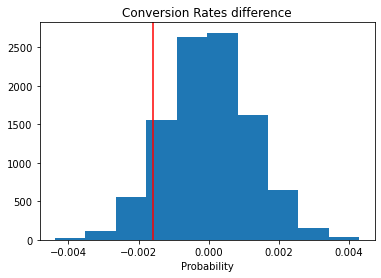

In [27]:
#compute observed difference in converted rate
obs_diffs=p_conver_treatment-p_conver_control
p_diffs=np.array(p_diffs)
#plot a histogram of p_diffs
plt.hist(p_diffs)
plt.title("Conversion Rates difference")
plt.xlabel("Probability")
plt.axvline(obs_diffs,color='r')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
(p_diffs>=obs_diffs).mean()

0.9076

k. What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

This is a p-value its probability of observing at least one extreme in favor of the alternative if the null hypothesis is true.  Small p-values suggest null is not true, large suggest null is true. In our case, it is the probability of observing no difference between conversion rates if the null hypothesis is true.
Base on the p-value above we fail to reject the null hypothesis.


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
#Import regression model library
import statsmodels.api as sm
#number of conversions for each page
convert_old = df2[(df2.group=='control')&(df2.converted==1)]['converted'].shape[0]
convert_new = df2[(df2.group=='treatment')&(df2.converted==1)]['converted'].shape[0]
#number of user for each page
n_old = df2[df2.landing_page=='old_page'].shape[0]
n_new = df2[df2.landing_page=='new_page'].shape[0]


In [30]:
convert_old,convert_new,n_old,n_new

(17489, 17264, 145274, 145310)

m. using  `stats.proportions_ztest` to compute the test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [31]:
#compute z-score and p-value
stat, pval=sm.stats.proportions_ztest([convert_new, convert_old],[n_new, n_old],alternative='larger')
stat, pval

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z-score is measured in terms of standard deviation from the mean. Yes, both values agree with the findings.

<a id='regression'></a>
### Part III - A regression approach

The result achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should  be performing in this case?

Logistic regression, to predict one of two categorical responses.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However,first I need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
#create intercept columns
df2['intercept']=1
#dummy variable columns for each landing page
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Using **statsmodels** to instantiate the regression model on the two columns created in part b., then fit the model using the two columns created in part **b.** to predict whether or not an individual converts. 

In [33]:
#Logit regression model for conveted and old_page as baseline
lm= sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result=lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of model below.

In [34]:
#model summary
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-09-29 05:34 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value found in **Part II**?<br><br>

 ab_page  p-value is 0.1899. still fail to reject the null hypothesis. Because Logit regression is base on a two-tailed test and in part II based on a one-sided test. In part II test was for the difference but in part III the test for equality.

f. considering other things that might influence whether or not an individual converts. why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

There might be many factors that significantly affect the conversion rate. but that may lead to Contradictory results.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in.

Does it appear that country had an impact on conversion? 

In [35]:
#read countries dataset
countries=pd.read_csv('countries.csv')
#merge ab_data dataset and countries dataset
df3=df2.merge(countries, how='inner')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US


In [36]:
#check unique countries 
df3.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [37]:
#dummy variables 
df3[['CA','UK','US']]=pd.get_dummies(df3.country)
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US,0,0,1


In [38]:
#Logit regression model for conveted and country, and CA as baseline
lm2=sm.Logit(df3['converted'],df3[['intercept','UK','US']])
result=lm2.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2021-09-29 05:34 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

still fails to reject the null hypothesis, the p-values above 0.05, countries don’t impact conversion rate.

h. Now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results.

In [39]:
#a new intereacton variable between ab_page and country US and UK
df3['UK_new'] = df3['UK'] * df3['ab_page']
df3['US_new'] = df3['US'] * df3['ab_page']

In [40]:
#Logit regression model for interaction between page and contry
lm3=sm.Logit(df3['converted'],df3[['intercept','ab_page', 'UK', 'US',  'UK_new', 'US_new']])
result=lm3.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-09-29 05:34 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK_new         0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US_new         0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

### Conclusion
In end, we fail to reject the null hypothesis. there is no sufficient evidence to suggest that the new page results in more conversions than the old page.
